In [1]:
import logging
from dask.distributed import Client, LocalCluster

In [2]:
dask_logger = logging.getLogger("distributed.utils_perf")
dask_logger.setLevel(logging.ERROR)

In [3]:
dask_cluster = LocalCluster(
    n_workers=20,
    threads_per_worker=1)
dask_client = Client(dask_cluster)

In [4]:
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 20
Total threads: 20,Total memory: 31.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45887,Workers: 20
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.14 GiB
Comm: tcp://127.0.0.1:38439,Total threads: 1
Dashboard: http://127.0.0.1:44753/status,Memory: 1.56 GiB
Nanny: tcp://127.0.0.1:40525,


# Cleanly shut down Dask cluster

In [5]:
dask_cluster.close()

2023-06-13 16:01:19,086 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


# Join English and Tibetan dataframes

In [5]:
from cai_common.data import TeiLoader, KangyurLoader

In [6]:
en_df = TeiLoader('kangyur').dataframe
en_df['location'] = en_df.location.fillna(0).astype(int)
en_df = dask_client.persist(en_df)

In [7]:
len(en_df)

In toh101, the current page was 453 which is larger than the end page 452 for volume 48, xml:id=UT22084-048-001-4468


19298

In [8]:
en_df.head()

,filename,tohoku_number,volume_number,location,text
0,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,0,The Translation The Noble Mahāyāna Sūtra Th...
1,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,394,Homage to all buddhas and bodhisattvas! Thu...
2,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,395,This is also what causes the variety of being...
3,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,396,"“Lord of nāgas, this dominion of yours like..."
4,058-003_toh154-the_sutra_of_the_questions_of_t...,toh154,58,397,for nonvirtuous thoughts and mental states to...


In [9]:
bo_df = KangyurLoader().remove_new_lines().dataframe
bo_df['location'] = bo_df.location.astype(int)
bo_df = dask_client.persist(bo_df)

In [10]:
len(bo_df)

65461

In [11]:
bo_df.head()

,filename,volume_number,location,text
0,v076_pages.txt,76,0,༄༅། །མདོ་སྡེ་ཨཱཾཿ་ཞུགས་སོ།།
1,v076_pages.txt,76,1,༄༅༅། །རྒྱ་གར་སྐད་དུ། པུ་ཎྱ་བ་ལ་ཨ་བ་དཱ་ན། བོད་ས...
2,v076_pages.txt,76,2,པར་བླངས་ཏེ་གནས་པར་མ་བྱས་པས་ལུས་ཞིག་སྟེ་ཤི་བའི་...
3,v076_pages.txt,76,3,བའི་ལས་དག་བྱེད་པ་ཡིན། །དམ་པ་མིན་པས་མི་རྟོགས་ཏེ...
4,v076_pages.txt,76,4,ཚེ་དང་ལྡན་པ་མ་འགགས་པ་དང་། ཚེ་དང་ལྡན་པ་ཤཱ་རིའི་...


# Load translator

In [22]:
import os

from cai_garland.utils.translator import Translator

In [25]:
# translator = Translator(os.path.join("olive-cormorant-nllb", "base-600M"))
translator = Translator(os.path.join("olive-cormorant-bart", "base-base"))

translator.num_beams = 20
translator.decoding_length = 200

# translator.prepare_context_encoder("facebook/bart-base")

translator.cuda()

## Create helpers from lotsawa-translate config

In [14]:
import hydra

hydra.__version__

'1.2.0'

In [15]:
with hydra.initialize(version_base="1.2", config_path="../../lotsawa/src/lotsawa/translation_config/"):
    translator_cfg = hydra.compose(config_name="translate")
    generation_cfg = translator_cfg.generation

In [16]:
translator.hard_segmenter = hydra.utils.instantiate(generation_cfg.segmentation.hard_segmentation)

translator.preprocessors = [
    hydra.utils.instantiate(preproc_func)
    for preproc_func in generation_cfg.processing.preprocessing
]

translator.soft_segmenter = hydra.utils.instantiate(
    generation_cfg.segmentation.soft_segmentation, translator=translator)

translator.soft_segment_combiner_config = getattr(generation_cfg.segmentation, "soft_segment_combiner", None)
translator.soft_segment_preprocessors = [
    hydra.utils.instantiate(preproc_func)
    for preproc_func in generation_cfg.processing.get("soft_segment_preprocessing", [])
]

translator.postprocessors = [
    hydra.utils.instantiate(preproc_func)
    for preproc_func in generation_cfg.processing.postprocessing
]

## Load processors of English text

In [17]:
with hydra.initialize(version_base="1.2", config_path="../../garland/src/cai_garland/data/dataset_prep.config/"):
    processor_cfg = hydra.compose(config_name="parallel_dataset_prep")

In [18]:
from cai_garland.utils.str_processors import ProcessorSymbolCleaningJSON

ProcessorSymbolCleaningJSON.base_dir = os.path.dirname("../../garland/src/cai_garland/data/")

In [19]:
en_processors_1 = [hydra.utils.instantiate(proc) for proc in processor_cfg.stages['naive-concats-sequenced'].dataset.preprocessing.target_lang]
en_processors_2 = [hydra.utils.instantiate(proc) for proc in processor_cfg.output.postprocessing.target_lang]

en_processors = en_processors_1 + en_processors_2
del en_processors_1, en_processors_2

In [20]:
def process_en_text(en_text):
    for processor in en_processors:
        en_text = processor(en_text)
    return en_text

In [39]:
with translator.tokenizer.as_target_tokenizer():
    tkns = translator.tokenizer.encode(
        "hi there. this is a test of what happens to periods, another test sentence.", add_special_tokens=False)
tkns

/home/eeisenst/workspace/contribs/original/transformers/src/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


[294,
 2700,
 90571,
 1559,
 174,
 9,
 3068,
 305,
 2610,
 39622,
 149,
 65429,
 90575,
 11000,
 3068,
 40447,
 90571]

In [33]:
with translator.tokenizer.as_target_tokenizer():
    tkns1 = translator.tokenizer("hi there.")
with translator.tokenizer.as_target_tokenizer():
    tkns2 = translator.tokenizer("this is a test of what happens to periods,")
with translator.tokenizer.as_target_tokenizer():
    tkns3 = translator.tokenizer("another test sentence.")
tkns1, tkns2, tkns3

({'input_ids': [90590, 90590, 294, 2700, 90571, 2], 'attention_mask': [1, 1, 1, 1, 1, 1], 'tokens_fixed': [1]},
 {'input_ids': [90590, 90590, 1559, 174, 9, 3068, 305, 2610, 39622, 149, 65429, 90575, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'tokens_fixed': [1]},
 {'input_ids': [90590, 90590, 11000, 3068, 40447, 90571, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'tokens_fixed': [1]})

In [60]:
# with translator.tokenizer.as_target_tokenizer():
#     print(translator.tokenizer.eos_token_id)
translator.tokenizer.target_tokenizer.__dict__.keys()
# translator.tokenizer.target_tokenizer.lang_code_to_id[translator.tokenizer.target_tokenizer.tgt_lang]
# translator.tokenizer.target_tokenizer.bos_token_id
with translator.tokenizer.as_target_tokenizer():
    print(translator.tokenizer.encode("")[-1:])

[2]


In [34]:
with translator.tokenizer.as_target_tokenizer():
    print(translator.tokenizer.decode(tkns['input_ids']))

eng_Latneng_Latn hi there. this is a test of what happens to periods, another test sentence.</s>


In [36]:
with translator.tokenizer.as_target_tokenizer():
    print(translator.tokenizer.decode(tkns2['input_ids']))

eng_Latneng_Latn this is a test of what happens to periods,</s>


In [62]:
with translator.tokenizer.as_target_tokenizer():
    tkns1 = translator.tokenizer("hi there.", return_tensors="pt")
tkns1

{'input_ids': tensor([[90590, 90590,   294,  2700, 90571,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]]), 'tokens_fixed': [1]}

# Test of individual segments

In [ ]:
# en_df.sample(frac=0.1).compute().sample(frac=0.01).sort_values('tohoku_number')
# en_df[en_df.tohoku_number == 'toh257'].compute().sample(frac=0.05).sort_values('tohoku_number')
en_df[en_df.tohoku_number == 'toh686'].compute().sample(frac=0.02).sort_values('tohoku_number')

In [ ]:
volume_number, location = 92, 362

In [ ]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location - 1)].compute().text.values[0]

In [ ]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location)].compute().text.values[0]

In [ ]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location + 1)].compute().text.values[0]

In [ ]:
en_df[(en_df.volume_number == volume_number) & (en_df.location == location)].compute()

In [ ]:
en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."

In [ ]:
en_text = en_df[(en_df.volume_number == volume_number) & (en_df.location == location)].compute().text.values[0]
en_text

In [ ]:
bo_text = "།རིགས་ཀྱི་བུ་ཁྱོད་ཀྱང་ད་ལྟར་ཏིང་ངེ་འཛིན་ལས་ལངས་པས་རིགས་ཀྱི་བུ་ཁྱོད་ད་མི་མཇེད་ཀྱི་འཇིག་རྟེན་གྱི་ཁམས་སུ་འགྲོ་བར་བྱའོ།"
bo_text = "།རིགས་ཀྱི་བུ་སངས་རྒྱས་ཀྱི་ཞིང་མི་མཇེད་དེ་ན་ནི་སེམས་ཅན་རྣམས་ཤིན་ཏུ་སྲེད་པའི་ཀུན་ཏུ་སྦྱོར་བ་དང་ལྡན་ཞིང་སྲིད་པའི་ལྟུང་ལ་བཏགས་པ་དག་ཡིན་ཏེ།"
bo_text = "སངས་རྒྱས་ཀྱི་ཞིང་དེ་ན་ནང་ན་ཡང་བུད་མེད་གཟུགས་མི་སྡུག་པ་དང་། ཚུལ་དུ་མི་ཤིས་པ་དང་། མཆོག་ཏུ་གཟུགས་ཀྱི་རྒྱགས་པས་དྲེགས་པ་དང་།"
bo_text = "དྲི་ང་བ་དང་། མི་གཙང་བ་དང་། གཙང་སྦྲར་སྤྱོད་པའི་རྒྱགས་པས་དྲེགས་པ་དང་།"
bo_text = "ངོ་གཉིས་བྱེད་པ་དང་། བདེན་པ་མ་ཡིན་པའི་ཚིག་སྨྲ་བ་དང་། ཚངས་པར་སྤྱོད་པར་ང་རྒྱལ་བྱེད་པ་དང་།"
bo_text = "།བུད་མེད་ཀྱི་ཉེས་པས་དགེ་བའི་རྩ་བ་ཐམས་ཅད་ལས་ཡོངས་སུ་ཉམས་པ་དག་དང་། ངན་སོང་བ་དག་དང་། སེམས་ཅན་དམྱལ་བ་པ་དག་ཏུ་འགྱུར་བ་ཡིན་ནོ།"
bo_text = "།རིགས་ཀྱི་བུ་ཁྱེད་དེ་བཞིན་གཤེགས་པ་ཤཱཀྱ་ཐུབ་པ་དེ་ལ་ངའི་བཀས་ཞུ་བའི་ཕྱིར་ངའི་བཀས་མི་མཇེད་ཀྱི་འཇིག་རྟེན་གྱི་ཁམས་སུ་འགྲོ་བར་སྤྲོ་ན། དེར་ཉི་མའི་སྙིང་པོའི་ཆོས་ཀྱིས་གནས་པ་ཀླུའི་ཡུལ་རྣམ་པར་འཇིག་པར་མཛད་པའི་འོད་ཟེར་གྱི་ལེའུ་སེམས་ཅན་རྣམས་ཀྱི་ལས་ཟད་པར་འགྱུར་བའི་གཟུངས་སྔགས་ལ་ང་དད་པ་སྦྱིན་པར་མཛད་དོ།"

bo_text = "།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ།"
bo_text = "སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ།"
# bo_text = "།དེ་ནས་དོན་ཡོད་པ་པདྨའི་གཙུག་ཏོར་དྲན་པ་ཙམ་གྱིས། བྱ་བ་ཐམས་ཅད་ནི་གཉིས་སུ་འགྱུར་ཏེ།"
bo_text = "གཞོན་ནུ་དང་། སྡེ་དཔོན་དང་། དེ་བཞིན་དུ་རྒྱལ་པོ་ཆེན་པོ་བཞི་དུས་རྟག་ཏུ་རིག་སྔགས་འཆང་གི་རྗེས་སུ་འབྲང་བར་བྱེད་དོ།"

In [ ]:
bo_text, translator.translate(bo_text)

In [ ]:
# en_text = 'This maṇḍala brings every accomplishment and causes the vidyā holder’s realization, merit, and splendor to grow. It is effective for removing all diseases and eradicating evil and vice. It heals wounds, injuries, and broken bones and destroys poisons and kākhordas. It also removes chronic diseases, ailments, and fevers.'
# en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat."

# en_text = 'This maṇḍala brings every accomplishment and causes the vidyā holder’s realization, merit, and splendor to grow. It is effective for removing all diseases and eradicating evil and vice.'
# en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco."

# en_text = 'it is the accomplishment of removing all illness. it destroys bad karma and bad karma.'
# en_text = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt."

In [ ]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [ ]:
from torch.nn.functional import log_softmax

def get_total_logits(bo_text, cur_en_text):
    bo_tokens = translator.tokenizer(bo_text, return_tensors="pt")
    with translator.tokenizer.as_target_tokenizer():
        en_tokens = translator.tokenizer(cur_en_text, return_tensors="pt")

    model_inputs = {
        'input_ids': bo_tokens.input_ids.to(translator.model.device),
        'attention_mask': bo_tokens.attention_mask.to(translator.model.device),
        # 'decoder_input_ids': en_tokens.input_ids.to(translator.model.device),
        # 'decoder_attention_mask': en_tokens.attention_mask.to(translator.model.device),
        'labels': en_tokens.input_ids.to(translator.model.device),
    }

    return -float(translator.model(**model_inputs).loss.to("cpu"))# / en_tokens.input_ids.shape[-1]

    model_logits = translator.model(**model_inputs).logits[0].to("cpu")
    # total_logit = float(log_softmax(model_logits[1:][:,en_tokens.input_ids[0][:-1].to("cpu")].diagonal()).sum()) / model_logits.shape[0]
    total_logit = float(log_softmax(model_logits[:,en_tokens.input_ids[0].to("cpu")].diagonal()).sum()) / model_logits.shape[0]
    return(total_logit)

In [ ]:
from tqdm.auto import tqdm

def score_segment(bo_segment, en_text, tqdm=tqdm):
    all_logits = []
    # splits = [t.strip() for t in remove_accents(en_text.lower()).replace("!", ".").replace("“", "").replace("—", ", ").split('.')]
    splits = [t.strip() for t in en_text.split(',') if len(t) > 0]
    for start_idx in tqdm(range(len(splits))):
        for end_idx in tqdm(range(start_idx + 1, len(splits) + 1), leave=False):
            cur_en_text = '. '.join(splits[start_idx:end_idx]) + '.'
            all_logits.append(((cur_en_text, start_idx, end_idx), get_total_logits(bo_segment, cur_en_text)))
    return sorted(all_logits, key=lambda x: -x[1])

In [ ]:
score_segment(bo_text, en_text)[:10]

# Test for longer text with segmentation

## Load some longer Tibetan text

In [36]:
volume_number, location = 92, 362

In [37]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location - 1)].compute().text.values[0]

'རས་གཟིགས་དབང་ཕྱུག་གིས། དོན་ཡོད་ཞགས་པའི་སྙིང་པོའི་གསང་སྔགས་འདི་སྨྲས་སོ། །ཨོཾ་ཨ་མོ་གྷ་པཱ་ཤ་ཧྲྀ་ད་ཡ་པདྨོཥྞཱི་ཥ་ཀུ་མཱ་ར་བེ་ཥ་དྷ་ར། པདྨེ་ཤྭ་ར། ཨཱ་བེ་ཤ་ཡ། སརྦ་ཨ་མོ་གྷ་ཀུ་ལ་ས་མ་ཡ་ཧྲྀ་ད་ཡ། སརྦ་སིདྡྷི་ཨ་མོ་གྷ་པྲ་ཡཙྪ་པདྨ། པདྨ་ཧཱུྃ་ཧཱུྃ་ན་མ་སྟུ་ཏེ་སྭཱ་ཧཱ། འདི་ནི་དོན་ཡོད་ཞགས་པའི་སྙིང་པོ་བཀླགས་པས་གྲུབ་པའི་སྒྲུབ་ཐབས་སོ། །ཨོཾ་ཨ་མོ་གྷ་པདྨོ་ཥྞཱི་ཥེ་ཤྭ་ར། པདྨེ་ཤྭ་ར། ས་མནྟཱ་ཡ་སརྦ་ཏ་ཐཱ་ག་ཏཱ་ནཱཾ། ཨ་མོ་གྷ་པདྨོཥྞཱི་ཥ་ས་མ་ཡ་ཨཱ་ཀརྵ་ཡ། པྲ་བེ་ཤ་ཡ། སརྦ་ཀརྨ་སིདྡྷིམྨེ་པྲ་ཡཙྪ་ཨ་བ་ལོ་ཀི་ཏེ་ཤྭ་ར་ཧཱུཾ་ཧཱུཾ། མ་ཧཱ་པདྨོཥྞཱི་ཥ་བྷུ་ཛེ་སྭཱ་ཧཱ། རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་སོ། །ཨོཾ་ཨ་ཧཱ་ཙནྜ་པདྨེ་ཤྭ་ར་བི་བི་དྷ་རཱུ་པ། བི་ཀ་ཊ། པདྨ་དཾཥྜ་ཀེ་རཱ་ལ་བྷཱི་ཥ་ཎ། བཱཀྟྲ་སརྦ་དུཥྚ་ཧྲྀ་ད་ཡཾ། ཁཱ་ད་ཡ། བིགྷ་ནཱཾ། པདྨ་དྷྲི་ཀ །ཙི་ཊི། དྲི་ཊི་ཧཱུཾ་སྭཱ་ཧཱ། ཁྲོ་བོའི་རྒྱལ་པོའི་རིགས་ཀྱི་སྙིང་པོའོ། །ནང་གི་དཀྱིལ་འཁོར་གསང་བའི་ལས་རྣམས་སོ། །ཨོཾ་ཨ་མོ་གྷ་པདྨོཥྞཱི་ཥ་པདྨ་པཱ་ཤ་ཀྲོ་དྷ་ཀ །མོ་ཡ་ཀརྨ་པྲ་བེ་ཤ་ཡ་མ་ཧཱ་བཱ་ཤུ་པ་ཏི། ཡ་མ། བ་རུ་ཎ། ཀུ་བེ་ར། བྲཧྨ་བེ་ཥ་དྷ་ར། མ་ཧཱ་ཙཎྜ་བེ་ག །ཨ་མོ་གྷ་ཀུ་ལས་མ་ཡ། པདྨེ་ཧཱུཾ་ཧཱུཾ། ཁྲོ་བོའི་རྒྱལ་པོ་དོན་ཡོད་ཞགས་པའི་པདྨ་གཙུག་ཏོར་གྱི་སྙིང་པ

In [38]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location)].compute().text.values[0]

'པའི་དཔལ་ཐོབ་བོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ། །པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ། བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ། །པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ། དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ། རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ། །སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། །རིགས་ཀྱི་རིག་པས་ལྷའི་དབང་ཕྱུག་དང་། ལྷའི་ཚོགས་རྣམས་ཀྱི་དབང་ཕྱུག་ཏུ

In [39]:
bo_df[(bo_df.volume_number == volume_number) & (bo_df.location == location + 1)].compute().text.values[0]

'དང་། སྲིན་པོ་དང་། འབྱུང་པོ་དང་། གཟའ་དང་། བརྗེད་བྱེད་དང་། མི་བཟད་པ་དེ་རྣམས་ཐམས་ཅད་ཁྲོ་བོའི་རྒྱལ་པོ་དྲན་པ་ཙམ་གྱིས་འཇིགས་པར་འགྱུར་རོ། །ཁྲོ་བོའི་རྒྱལ་པོའི་གསང་བ་ཐམས་ཅད་ཀྱི་རིགས་ཀྱི་དམ་ཚིག་ལ་གནས་པ་དང་། དཀྱིལ་འཁོར་དུ་ཕྱག་རྒྱ་གནས་པ་དང་། གསང་སྔགས་ཀྱི་ལྷ་གཞན་གང་ཡིན་པ་རྣམས་ཀྱིས་ཁྲོ་བོའི་རྒྱལ་པོ་དྲན་པ་ཙམ་གྱིས་དེ་རྣམས་ཐམས་ཅད་རིག་སྔགས་འཆང་ལ་སྐྱབས་སུ་འགྲོ་བར་བྱེད་དོ། །དེ་རྣམས་ཐམས་ཅད་རྗེས་སུ་འབྲང་བར་འགྱུར་ཞིང་གནས་པར་བྱེད་དོ། །འགའ་ཞིག་གང་དུ་འགྲོ་བའམ་འདུག་པ་དེ་ལ་དབང་པོ་དང་། སྐབས་གསུམ་པའི་ལྷ་དང་། ཚངས་པ་དང་། ཁྱབ་འཇུག་དང་། དབང་ཕྱུག་ཆེན་པོ་དང་། གཤིན་རྗེ་དང་། ཆུ་ལྷ་དང་། ཀླུའི་རྒྱལ་པོ་རྒྱ་མཚོ་དང་། དགའ་བོ་དང་། ཉེ་དགའ་བོ་དང་། གཞོན་ནུ་དང་། སྡེ་དཔོན་དང་། དེ་བཞིན་དུ་རྒྱལ་པོ་ཆེན་པོ་བཞི་དུས་རྟག་ཏུ་རིག་སྔགས་འཆང་གི་རྗེས་སུ་འབྲང་བར་བྱེད་དོ། །ཐེ་ཚོམ་མེད་དོ། །ཁྲོས་པའི་ལས་རྣམས་སམ། དེ་བཞིན་དུ་དྲག་པོའི་ལས་རྣམས་ཐམས་ཅད་ཀྱང་ཧཱུཾ་ཡིག་ཙམ་གྱིས་དེ་ལ་དངོས་གྲུབ་མཐོང་ངོ་། །ཕྱིར་རྒོལ་བ་དང་། དགྲ་དང་། སེམས་ཅན་མ་རུངས་པ་ཤིན་ཏུ་མི་བཟད་པ་རྣམས་དང་། ཕ་རོལ་གྱི་དམག་ཚོགས་དང་འཇིགས་པ་དང་། རྣམ་པར་འགྲས་པའི་སྐྱེ་བོ་དང་། སྡིག་པ་དེ་རྣམས་ཐམས་ཅད་ཧཱུཾ་ཡ

In [40]:
bo_text = "བླ་ན་མེད་པའི་དཔལ་ཐོབ་བོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ། །པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ། བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ། །པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ། དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ། རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ། །སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། །རིགས་ཀྱི་རིག་པས་ལྷའི་དབང་ཕྱུག་དང་། ལྷའི་ཚོགས་རྣམས་ཀྱི་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །རྟག་ཏུ་ཡང་གནོད་སྦྱིན་རྣམས་དང་། སྲིན་པོ་རྣམས་སུ་གྱུར་པ་དང་། དྲི་ཟ་རྣམས་དང་། གནོད་སྦྱིན་རྣམས་དང་། སྲིན་པོ་རྣམས་ཀྱི་དེ་བཞིན་ཉིད་དུ་ཐམས་ཅད་དུ་རྒྱལ་པོ་དང་། དབང་ཕྱུག་ཏུ་རྟག་ཏུ་འགྱུར་ཏེ་ཐེ་ཚོམ་མེད་དོ། །ནམ་མཁའ་ལྡིང་རྣམས་དང་། མིའམ་ཅི་རྣམས་དང་། ལྟོ་འཕྱེ་ཆེན་པོ་རྣམས་དང་། ཐམས་ཅད་དུ་ཇི་སྲིད་བྱང་ཆུབ་ལ་ཡང་དག་པར་གནས་ཀྱི་བར་དུ་རིགས་ཀྱི་རྒྱལ་པོར་འགྱུར་རོ། །དེ་ནས་ཁྲོ་བོའི་རྒྱལ་པོ་དྲན་པ་ཙམ་དང་དྲག་པོ་དེ་ཡིད་ལ་སེམས་པ་ཙམ་གྱི་མོད་ལ། འཕྲལ་དུ་རི་རབ་ལྟུང་བར་བྱེད་ཅིང་། ཁོར་ཡུག་གི་རི་རྣམ་པར་འཐོར་བར་བྱེད་དོ། །རྒྱ་མཚོ་ཆེན་པོ་ཀུན་ནས་དཀྲུག་ཅིང་། རྒྱ་མཚོ་ཆེན་པོ་ཉེ་བར་སྐྱེ་བར་བྱེད་དོ། །ཀུན་དུ་གསལ་བར་བྱེད་དོ། །ཀླུའི་གནས་ཐམས་ཅད་དུ་ཀླུའི་གནས་འབར་བར་ཡང་བྱེད་དོ། །བགེགས་དང་ལོག་པར་འདྲེན་པ་ཐམས་ཅད་ཀྱི་སྐད་ཅིག་ཙམ་གྱིས་སྟེང་དུ་བདུག་པར་བྱེད་དོ། །གནོད་སྦྱིན་དང་།"
bo_text

'བླ་ན་མེད་པའི་དཔལ་ཐོབ་བོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ། །རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ། །པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ། བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ། །པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ། དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ། རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ། །དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ། །སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། །རིགས་ཀྱི་རིག་པས་ལྷའི་དབང་ཕྱུག་དང་། ལྷའི་ཚོགས་རྣམས་ཀྱི་དབ

In [41]:
en_text = en_df[(en_df.volume_number == volume_number) & (en_df.location == location)].compute().text.values[0]
en_text

' If he mindfully repeats the mantra of the lord of the family, he will obtain the auspicious accomplishment of the lord of the family in the maṇḍala of Padmoṣṇīṣa. Family lords, as well as the mantra and vidyā kings who rule over the family lords’ auspicious accomplishments, will arrive and grant the vidyā holder every supreme accomplishment. Followed by Padmapāṇi, he will win the accomplishments of the amogha family. These kings of mantras will be accomplished through recitation; there is no doubt about this.  “Accomplishment in the Padmoṣṇīṣa family belongs to the great lotus maṇḍala, the maṇḍala of Amoghapāśa, where one becomes accomplished through recitation. Through mere recitation, the vidyā holder will become the lord of the family and the king of the vidyādharas—a sovereign lord in every respect. Using the rites and mudrās of the corresponding maṇḍalas, he will join the same family as the bodhisattvas and will perform the function of a king in every respect. Using the family v

In [42]:
segments = list(translator.segment(bo_text))
segments

Hard segments:   0%|          | 0/1 [00:00<?, ?it/s]

Segmenting:   0%|          | 0/39 [00:00<?, ?it/s]

['།བླ་ན་མེད་པའི་དཔལ་ཐོབ་བོ།',
 '།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ།',
 'ཐམས་ཅད་དུ་རིགས་ཀྱི་རྒྱལ་པོའི་དངོས་གྲུབ་བཟང་པོ་རྣམས་འོང་བར་འགྱུར་རོ།',
 '།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་མཆོག་གི་དངོས་གྲུབ་ཐམས་ཅད་རབ་ཏུ་སྦྱིན་པར་བྱེད་དོ།',
 '།པདྨའི་ཕྱག་གིས་རྗེས་སུ་འཇུག་ཅིང་། དོན་ཡོད་པའི་རིགས་ཀྱི་དངོས་གྲུབ་ཇི་ལྟ་བ་བཞིན་དུ་འགྲུབ་སྟེ།',
 'བཀླགས་པས་གྲུབ་པ་འདི་ལ་ཐེ་ཚོམ་མེད་དོ།',
 '།པདྨ་གཙུག་ཏོར་གྱི་རིགས་ཀྱི་དངོས་གྲུབ་དང་། པདྨ་ཡངས་པའི་དཀྱིལ་འཁོར་རམ།',
 'དོན་ཡོད་ཞགས་པའི་དཀྱིལ་འཁོར་དུ་བཀླགས་ནས་བཟླས་པ་ཙམ་གྱིས་འགྲུབ་སྟེ།',
 'རིགས་ཀྱི་རྒྱལ་པོ་དང་། རིག་སྔགས་ཀྱི་རྒྱལ་པོ་གང་ཡིན་པ་དེ་ཐམས་ཅད་དུ་དབང་ཕྱུག་ཏུ་འགྱུར་རོ།',
 '།དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ།',
 '།སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ།',
 '།རིགས་ཀྱི་ར

In [43]:
en_text = process_en_text(en_text)

In [44]:
segment_scores = {}
for segment in tqdm(segments, leave=False):
    segment_scores[segment] = score_segment(segment, en_text, tqdm=lambda *args, **kwargs: tqdm(*args, disable=True, **kwargs))

  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
final_matches = {}

In [46]:
while len(segment_scores) > 0:
    best_match = max(
        [(segment, scores[0]) for segment, scores in segment_scores.items()],
        key=lambda x: x[1][1])
    best_bo, ((best_en, best_en_start, best_en_end), best_score) = best_match
    final_matches[best_bo] = (best_en, best_score)

    del segment_scores[best_bo]

    new_segment_scores = {}
    for segment, scores in segment_scores.items():
        new_segment_scores[segment] = [((en, en_start, en_end), score) for (en, en_start, en_end), score in scores if not (best_en_start >= en_start and best_en_end <= en_end)]
    segment_scores = new_segment_scores

In [47]:
final_matches

{'།གནོད་སྦྱིན་དང་།།': ('as well as of yaksas.', -1.5338767766952515),
 '།སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ།': ('he will become king in hundreds of thousands of buddha fields.',
  -1.6311500072479248),
 '།ཀུན་དུ་གསལ་བར་བྱེད་དོ། །ཀླུའི་གནས་ཐམས་ཅད་དུ་ཀླུའི་གནས་འབར་བར་ཡང་བྱེད་དོ།': ('all naga dwellings will burn.',
  -1.9746745824813843),
 '།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ།': ('he will obtain the auspicious accomplishment of the lord of the family in the mandala of padmosnisa. family lords.',
  -2.062058687210083),
 '།དཀྱིལ་འཁོར་རྣམས་ཀྱི་ཆོ་ག་ཞིབ་མོ་དང་། ཕྱག་རྒྱས་བྱང་ཆུབ་སེམས་དཔའ་ཐམས་ཅད་ཀྱི་རིགས་ཐུན་མོང་བ་ཐམས་ཅད་དུ་རྒྱལ་པོའི་བྱ་བ་བྱེད་པར་འགྱུར་རོ།': ('he will join the same family as the bodhisattvas and will perform the function of a king in every respect. using the family vidya.',
  -2.0876047611236572),
 '།རིགས

In [48]:
for bo, (en, score) in tqdm(final_matches.items()):
    print(f"{bo} | {en} | {translator.translate(bo)} | {score}")

  0%|          | 0/20 [00:00<?, ?it/s]

།གནོད་སྦྱིན་དང་།། | as well as of yaksas. | yaksas, | -1.5338767766952515
།སངས་རྒྱས་ཀྱི་ཞིང་སྟོང་ཕྲག་རྣམས་དང་། སངས་རྒྱས་ཀྱི་ཞིང་བརྒྱ་ཕྲག་རྣམས་དང་། གང་གཱའི་ཀླུང་གི་བྱེ་མ་དང་མཉམ་པའི་ཞིང་དུ་རྒྱལ་པོར་འགྱུར་རོ། | he will become king in hundreds of thousands of buddha fields. | they will become kings in thousands of buddha realms, hundreds of buddha realms, and as many realms as there are grains of sand in the ganges. | -1.6311500072479248
།ཀུན་དུ་གསལ་བར་བྱེད་དོ། །ཀླུའི་གནས་ཐམས་ཅད་དུ་ཀླུའི་གནས་འབར་བར་ཡང་བྱེད་དོ། | all naga dwellings will burn. | it will illuminate the entire land of the nagas, and all the land of the nagas will blaze with light. | -1.9746745824813843
།རིགས་ཀྱི་རྒྱལ་པོའི་གསང་སྔགས་རྒྱས་པར་གྱུར་པ་པདྨ་གཙུག་ཏོར་གྱི་དཀྱིལ་འཁོར་དུ་རིགས་ཀྱི་རྒྱལ་པོ་ལེགས་པར་གྲུབ་པར་འགྱུར་ཏེ། | he will obtain the auspicious accomplishment of the lord of the family in the mandala of padmosnisa. family lords. | the secret mantra of the vidyaraja of the vidya family will be extensively accomplished in th

# Compare outputs

In [1]:
import os

import pandas as pd

In [2]:
bart_df = pd.read_csv(
    os.path.join(os.environ['CAI_TEMP_PATH'], "temp_data/mined_enbo_data/matches.csv.bart"),
    header=None,
    delimiter='|',
    names=["folio_idx", "bo", "en", "score"],
    index_col="folio_idx")
nllb_df = pd.read_csv(
    os.path.join(os.environ['CAI_TEMP_PATH'], "temp_data/mined_enbo_data/matches.csv.nllb"),
    header=None,
    delimiter='|',
    names=["folio_idx", "bo", "en", "score"],
    index_col="folio_idx")
joined_df = bart_df.join(nllb_df, lsuffix="_bart", rsuffix="_nllb")
joined_df

,bo_bart,en_bart,score_bart,bo_nllb,en_nllb,score_nllb
folio_idx,,,,,,
0,།༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ།།,the translation the chapters on monastic disci...,-4.600859,།༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ།།,the translation the chapters on monastic disci...,-3.656713
1,།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།,at first to renounce a householders concerns a...,-1.937958,།༄༅༅། །རྒྱ་གར་སྐད་དུ། བི་ན་ཡ་བསྟུ། བོད་སྐད་དུ།...,homage to the three jewels.,-0.552617
1,།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།,at first to renounce a householders concerns a...,-1.937958,།ངུར་སྨྲིག་གོས་འཆང་མཁས་པ་ཚུལ་ལས་ཉམས་པ་དཀའ།,for a learned wearer of the saffron robes to f...,-1.113399
1,།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།,at first to renounce a householders concerns a...,-1.937958,།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས...,"homage to him who severed the bonds, destroyed...",-1.154738
1,།ཁྱིམ་དོན་ཆེ་ཆུང་སྤངས་ཏེ་དང་པོར་རབ་འབྱུང་དཀའ།,at first to renounce a householders concerns a...,-1.937958,།གཞི་རྣམས་ཀྱི་སྤྱི་སྡོམ་ལ། རབ་འབྱུང་གསོ་སྦྱོང་...,the chapters on monastic discipline includes c...,-1.411704
...,...,...,...,...,...,...
70,།དེ་སྒོ་བས་བཞིན་གྱི་གཟུགས་ལས་ངོ་ཤེས་ནས་སྨྲས་པ།,"the village gatekeeper recognized him and asked,",-4.202088,NaN,NaN,NaN
70,།མེར་འཇུག་གི་བུ་འོ་ན་ཁྱོད་ཀྱིས་དེ་ལྟར་ཤེས་ཤིང་...,"son of a self-immolator, then know this: if yo...",-4.322667,NaN,NaN,NaN
70,།མེར་འཇུག་གི་བུ་ཁྱོད་ཀྱིས་བདག་ཐམས་ཅད་མི་བཟོད་པ...,"son of a self-immolator, even that view you ho...",-4.351613,NaN,NaN,NaN


<AxesSubplot: >

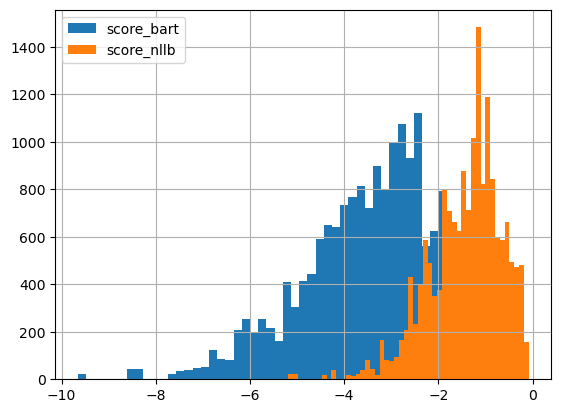

In [3]:
joined_df.score_bart.hist(bins=50, legend=True)
joined_df.score_nllb.hist(bins=50, legend=True)

In [4]:
bo_bart_df = bart_df.set_index('bo')
bo_bart_df = bo_bart_df[~bo_bart_df.index.duplicated()]

bo_nllb_df = nllb_df.set_index('bo')
bo_nllb_df = bo_nllb_df[~bo_nllb_df.index.duplicated()]

bo_joined_df = bo_nllb_df.join(bo_bart_df, lsuffix='_nllb', rsuffix='_bart', how='inner')
bo_joined_df

,en_nllb,score_nllb,en_bart,score_bart
bo,,,,
།༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ།།,the translation the chapters on monastic disci...,-3.656713,the translation the chapters on monastic disci...,-4.600859
།༄༅༅། །རྒྱ་གར་སྐད་དུ། བི་ན་ཡ་བསྟུ། བོད་སྐད་དུ། འདུལ་བ་གཞི། བམ་པོ་དང་པོ། དཀོན་མཆོག་གསུམ་ལ་ཕྱག་འཚལ་ལོ།,homage to the three jewels.,-0.552617,homage to the three jewels.,-2.867246
།ངུར་སྨྲིག་གོས་འཆང་མཁས་པ་ཚུལ་ལས་ཉམས་པ་དཀའ།,for a learned wearer of the saffron robes to f...,-1.113399,for a learned wearer of the saffron robes to f...,-2.591639
།གང་གིས་འཆིང་རྣམས་ཡང་དག་རབ་བཅད་ཅིང་། །མུ་སྟེགས་ཚོགས་རྣམས་ཐམས་ཅད་རབ་བཅོམ་སྟེ། །སྡེ་དང་བཅས་པའི་བདུད་རྣམས་ངེས་བཅོམ་ནས། །བྱང་ཆུབ་འདི་བརྙེས་དེ་ལ་ཕྱག་འཚལ་ལོ།,"homage to him who severed the bonds, destroyed...",-1.154738,"homage to him who severed the bonds, destroyed...",-3.765382
།གཞི་རྣམས་ཀྱི་སྤྱི་སྡོམ་ལ། རབ་འབྱུང་གསོ་སྦྱོང་གཞི་དང་ནི།,the chapters on monastic discipline includes c...,-1.411704,the chapters on monastic discipline includes c...,-4.495665
...,...,...,...,...
།བུ་ཁོ་བོ་ཡང་ཅུང་ཟད་རབ་ཏུ་བྱུང་བ་དེ་ཐམས་ཅད་བདུད་རྩི་དོན་དུ་གཉེར་ཞིང་བདུད་རྩི་ཚོལ་བ་ཡིན་ན་ཁོ་བོས་བདུད་རྩི་ཅུང་ཟད་ཀྱང་མ་རྙེད་དེ།,the whole of what little renunciation i have i...,-1.428485,the whole of what little renunciation i have i...,-1.590217
།དེ་རྒྱ་མཚོ་ལ་ཐུག་པའི་ས་ཆེན་པོ་མ་ལུས་པ་གནོད་པར་སྡོ་བ་མེད་ཅིང་འཚེ་བ་མེད་པ་འདི་ཉིད་ཆད་པ་མེད་ཅིང་མཚོན་གྱིས་བདའ་བ་མེད་ལ། ཆོས་དང་མཐུན་ཞིང་སྙོམས་པས་ལེགས་པར་ཕབ་སྟེ་གནས་པར་འགྱུར་རོ།,"the whole earth, from sea to sea, will be free...",-1.519169,where rule is impartial and in harmony with th...,-3.459297
དེའི་རིན་པོ་ཆེ་བདུན་པོ་དེ་དག་ནི་འདི་ལྟ་བུར་འགྱུར་ཏེ།,he will be endowed with the dharma or the seve...,-1.765414,allow me to explain.,-4.108505


In [5]:
(bo_joined_df.en_nllb == bo_joined_df.en_bart).sum()

257

In [6]:
i = 1

In [7]:
import os

from cai_garland.utils.translator import Translator

In [8]:
translator = Translator(os.path.join("olive-cormorant-nllb", "base-600M"))
# translator = Translator(os.path.join("olive-cormorant-bart", "base-base"))

translator.num_beams = 20
translator.decoding_length = 200

# translator.prepare_context_encoder("facebook/bart-base")

translator.cuda()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'NllbTokenizer'. 
The class this function is called from is 'CAINllbTokenizerFast'.


---

In [480]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index()[['en_nllb', 'en_bart']].loc[i].en_nllb

'yet when the tree is large, even a hundred axes may fail.'

In [481]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index().loc[i].score_nllb

-2.008854866027832

In [482]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index()[['en_nllb', 'en_bart']].loc[i].en_bart

'then they spoke in verse: when a tree is small, fingernails may fell it.yet when the tree is large, even a hundred axes may fail.'

In [483]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].reset_index().loc[i].score_bart

-3.823538064956665

In [484]:
bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].index[i]

'ཇི་སྲིད་ཤིང་ནི་གཞོན་པའི་ཚེ། །སེན་མོ་དག་གིས་གཅད་ནུས་པ། །དེ་ཉིད་ཆེན་པོར་སྐྱེས་པ་ན། །སྟ་རེ་བརྒྱས་ཀྱང་གཅད་པར་དཀའ།'

In [485]:
translator.translate(bo_joined_df[bo_joined_df.en_nllb != bo_joined_df.en_bart].index[i])

/home/eeisenst/workspace/contribs/original/transformers/src/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


'as long as the tree is young, it can be severed by the fingernails. it will be difficult to sever it with even a hundred axes. it will be difficult to sever it with a hundred axes.'

In [486]:
i += 1